### LeNet

In [1]:
import torch

In [2]:
torch.__version__

'0.4.1'

In [3]:
import torch.nn as nn

In [4]:
import torch.nn.functional as F

In [5]:
import torch.optim as optim

In [6]:
import torchvision

In [7]:
import torchvision.datasets as datasets

In [8]:
import torchvision.transforms as transforms

In [9]:
import os 
import random
import numpy as np 

#### 图像的Normalize

每个像素-mean/std

每个像素的归一化缩放

思考:

1.归一化哪部分数据？A训练集、B评测集、C训练集+评测集 -> C

2.归一化的参数mean和std来自于？A训练集、B评测集、C训练集+评测集 -> A

In [10]:
#np.mean(mnist.train.images)

In [11]:
#np.std(mnist.train.images)

#### 数据的归一化

In [12]:
data_trans=transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))#参数mean和std来自于训练集，但是transform本身在训练和评测的时候都会使用
])

In [13]:
data_trans_alexnet=transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))#参数mean和std来自于训练集，但是transform本身在训练和评测的时候都会使用
])

In [94]:
# train_data=datasets.MNIST('data',train=True,download=True,transform=data_trans)
# test_data=datasets.MNIST('data',train=False,download=True,transform=data_trans)

In [95]:
train_data=datasets.CIFAR10('data',train=True,download=True,transform=data_trans)
test_data=datasets.CIFAR10('data',train=False,download=True,transform=data_trans)

Files already downloaded and verified
Files already downloaded and verified


In [96]:
# train_data=datasets.MNIST('data',train=True,download=True,transform=data_trans_alexnet)
# test_data=datasets.MNIST('data',train=False,download=True,transform=data_trans_alexnet)

In [97]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train

In [98]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [99]:
len(train_data)

45000

In [100]:
len(valid_data)

5000

In [101]:
len(test_data)

10000

In [102]:
train_data.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: data
    Transforms (if any): Compose(
                             Resize(size=32, interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [103]:
batch_size=64

目前完成了数据集的制作

In [104]:
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [105]:
len(train_iterator)

704

#### 构建神经网络

In [109]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        #第一层conv1，因为是MNIST数据集，所有channel数是1，输出的channel是6,kernel_size是5*5
        self.conv1=nn.Conv2d(3,6,5)
        #第二层conv2,输入channel=6,输出channel=16，kernel5*5,input_size=14*14,output_size=10*10
        self.conv2=nn.Conv2d(6,16,5)
        
        self.fc1=nn.Linear(16*5*5,120)
        
        self.fc2=nn.Linear(120,84)
        
        self.fc3=nn.Linear(84,10)#不用增加softmax层，从推断的角度直接使用argmax就可以得到最终的预测结果，在cross_entropy函数中实现了softmax的功能
        
    def forward(self,x):#规定计算图架构
        out=F.max_pool2d(F.relu(self.conv1(x)),2)
        out=F.max_pool2d(F.relu(self.conv2(out)),2)
        out=out.view(out.shape[0],-1)
        out=F.relu(self.fc1(out))
        out=F.relu(self.fc2(out))
        out=self.fc3(out)
        return out
    
        

In [110]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.feature_block=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.class_block=nn.Sequential(
            nn.Dropout(),
            nn.Linear(6*6*256,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,10),
        )
    def forward(self,x):
        x=self.feature_block(x)
        x=self.avgpool(x)
        x=x.view(x.size(0),256*6*6)
        x=self.class_block(x)
        return x
        

In [111]:
class VGGBlock(nn.Module):
    def __init__(self,in_channel,out_channel,batch_norm):#改良后的新的VGGBlock
        super(VGGBlock,self).__init__()
        stack=[]
        stack.append(nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1))
        if batch_norm:
            stack.append(nn.BatchNorm2d(out_channel))
        stack.append(nn.ReLU(inplace=True))
        self.model_block=nn.Sequential(*stack)
    def forward(self,x):
        return self.model_block(x)

In [112]:
class VGGNet11(nn.Module):
    def __init__(self,block,pool,batch_norm):#block是一个网络模组抽象，pool也是pooling层的抽象
        super(VGGNet11,self).__init__()
        self.feature_block=nn.Sequential(
            block(3,64,batch_norm), #32*32
            pool(kernel_size=2,stride=2),#16*16
            block(64,128,batch_norm),
            pool(kernel_size=2,stride=2),#8*8
            block(128,256,batch_norm),
            block(256,256,batch_norm),
            pool(kernel_size=2,stride=2),#4*4
            block(256,512,batch_norm),
            block(512,512,batch_norm),
            pool(kernel_size=2,stride=2),#2*2
            block(512,512,batch_norm),
            block(512,512,batch_norm),
            pool(kernel_size=2,stride=2),#1*1
        )
        self.classifier=nn.Linear(512,10)
        
    def forward(self,x):
        x=self.feature_block(x)
        x=x.view(x.shape[0],-1)
        x=self.classifier(x)
        return x

In [113]:
class VGGNet16(nn.Module):
    def __init__(self,block,pool,batch_norm):#block是一个网络模组抽象，pool也是pooling层的抽象
        super(VGGNet16,self).__init__()
        self.feature_block=nn.Sequential(
            block(3,64,batch_norm), #32*32
            block(64,64,batch_norm),
            pool(kernel_size=2,stride=2),#16*16
            block(64,128,batch_norm),
            block(128,128,batch_norm),
            pool(kernel_size=2,stride=2),#8*8
            block(128,256,batch_norm),
            block(256,256,batch_norm),
            pool(kernel_size=2,stride=2),#4*4
            block(256,512,batch_norm),
            block(512,512,batch_norm),
            block(512,512,batch_norm),
            pool(kernel_size=2,stride=2),#2*2
            block(512,512,batch_norm),
            block(512,512,batch_norm),
            block(512,512,batch_norm),
            pool(kernel_size=2,stride=2),#1*1
        )
        self.classifier=nn.Sequential(
            nn.Linear(512,1024),
            nn.Linear(1024,1024),
            nn.Linear(1024,10),
        )
        
        
    def forward(self,x):
        x=self.feature_block(x)
        x=x.view(x.shape[0],-1)
        x=self.classifier(x)
        return x

### GoogleNet

In [114]:
class Inception(nn.Module):
    def __init__(self,in_planes,n1x1,n3x3red,n3x3,n5x5red,n5x5,pool_planes):
        super(Inception,self).__init__()
        self.b1=nn.Sequential(
            nn.Conv2d(in_planes,n1x1,kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )
        
        self.b2=nn.Sequential(
            nn.Conv2d(in_planes,n3x3red,kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red,n3x3,kernel_size=3,padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )
        
        self.b3=nn.Sequential(
            nn.Conv2d(in_planes,n5x5red,kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red,n5x5,kernel_size=5,padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )
        
        self.b4=nn.Sequential(
            nn.MaxPool2d(3,stride=1,padding=1),
            nn.Conv2d(in_planes,pool_planes,kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
        
    def forward(self,x):
        x1=self.b1(x)
        x2=self.b2(x)
        x3=self.b3(x)
        x4=self.b4(x)
        #concat4层输入在一起
        return torch.cat([x1,x2,x3,x4],1)

In [115]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet,self).__init__()
        self.feature_block=nn.Sequential(
            nn.Conv2d(3,192,kernel_size=3,padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        self.a3=Inception(192,64,96,128,16,32,32)
        self.b3=Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool=nn.MaxPool2d(3,stride=2,padding=1)
        self.a4 = Inception(480, 192,  96, 208, 16,  48,  64)
        self.b4 = Inception(512, 160, 112, 224, 24,  64,  64)
        self.c4 = Inception(512, 128, 128, 256, 24,  64,  64)
        self.d4 = Inception(512, 112, 144, 288, 32,  64,  64)
        self.e4 = Inception(528, 256, 160, 320, 32, 128, 128)
        self.a5 = Inception(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inception(832, 384, 192, 384, 48, 128, 128)
        self.avgpool=nn.AvgPool2d(8,stride=1)
        self.linear=nn.Linear(1024,10)
        
    def forward(self,x):
        out=self.feature_block(x)
        out=self.a3(out)
        out=self.b3(out)
        out=self.maxpool(out)
        out=self.a4(out)
        out=self.b4(out)
        out=self.c4(out)
        out=self.d4(out)
        out=self.e4(out)
        out=self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out =self.avgpool(out)
        out =out.view(out.size(0),-1)
        out=self.linear(out)
        return out

In [116]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(ResNetBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x)#ResNet的add操作，其实是张量的加和
        out = F.relu(out)
        return out

class ResNetLayer(nn.Module):
    def __init__(self,block,n_blocks,in_channels,out_channels,stride):
        super(ResNetLayer,self).__init__()
        self.modules=[]
        self.modules.append(block(in_channels,out_channels,stride))
        for _ in range(n_blocks-1):
            self.modules.append(block(out_channels,out_channels,1))
        self.blocks=nn.Sequential(*self.modules)
        
    def forward(self,x):
        return self.blocks(x)
    
class ResNet18(nn.Module):
    def __init__(self,layer,block):
        super(ResNet18,self).__init__()
        n_blocks=[2,2,2,2]
        self.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.rb1=layer(block,n_blocks[0],64,64,1)
        self.rb2=layer(block,n_blocks[1],64,128,2)
        self.rb3=layer(block,n_blocks[2],128,256,2)
        self.rb4=layer(block,n_blocks[3],256,512,2)
        self.fc=nn.Linear(512,10)
        
    def forward(self,x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.rb1(out)
        out=self.rb2(out)
        out=self.rb3(out)
        out=self.rb4(out)
        out=F.avg_pool2d(out,4)
        out=out.view(out.shape[0],-1)
        out=self.fc(out)
        return out
        
#ResNet34->[3,4,6,3]


In [117]:
import math
class Bottleneck(nn.Module):
    def __init__(self,in_planes,growth_rate):
        super(Bottleneck,self).__init__()
        self.bn1=nn.BatchNorm2d(in_planes)
        self.conv1=nn.Conv2d(in_planes,4*growth_rate,kernel_size=1,bias=False)
        self.bn2=nn.BatchNorm2d(4*growth_rate)
        self.conv2=nn.Conv2d(4*growth_rate,growth_rate,kernel_size=3,padding=1,bias=False)
        
    def forward(self,x):
        out=self.conv1(F.relu(self.bn1(x)))#pre-activation
        out=self.conv2(F.relu(self.bn2(out)))
        out=torch.cat([out,x],1)
        return out
class Transition(nn.Module):
    def __init__(self,in_planes,out_planes):
        super(Transition,self).__init__()
        self.bn=nn.BatchNorm2d(in_planes)
        self.conv=nn.Conv2d(in_planes,out_planes,kernel_size=1,bias=False)
    def forward(self,x):
        out=self.conv(F.relu(self.bn(x)))
        out=F.avg_pool2d(out,2)
        return out
class DenseNet(nn.Module):
    def __init__(self,block,nblocks,growth_rate=12,reduction=0.5,num_classes=10):
        super(DenseNet,self).__init__()
        self.growth_rate=growth_rate
        num_planes=2*growth_rate #32
        #最初的感知层
        self.conv1=nn.Conv2d(3,num_planes,kernel_size=3,padding=1,bias=False)
        #第一个DenseBlock
        self.dense1=self._make_dense_layers(block,num_planes,nblocks[0])
        num_planes+=nblocks[0]*growth_rate
        out_planes=int(math.floor(num_planes*reduction))
        self.trans1=Transition(num_planes,out_planes)
        num_planes=out_planes
        #第二个DenseBlock
        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate#计算如果不压缩的话的输出
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes
        #第三个DenseBlock
        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes
        #第四个DenseBlock
        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate
        #分类层
        self.bn=nn.BatchNorm2d(num_planes)
        self.linear=nn.Linear(num_planes,num_classes)
    
    
    def _make_dense_layers(self,block,in_planes,nblock):
        #block:bottleneck
        #nblock代表构建denseblock中有多少bottleneck层
        layers=[]
        for i in range(nblock):
            layers.append(block(in_planes,self.growth_rate))
            in_planes+=self.growth_rate
        return nn.Sequential(*layers)
    
    def forward(self,x):
        out=self.conv1(x)
        out=self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out=F.avg_pool2d(F.relu(self.bn(out)),4)
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck,[6,12,24,16],growth_rate=32)
    

#### ResNext

In [118]:
class Block(nn.Module):
    
    expansion = 2

    def __init__(self, in_planes, cardinality=32, bottleneck_width=4, stride=1):
        super(Block, self).__init__()
        group_width = cardinality * bottleneck_width
        self.conv1 = nn.Conv2d(in_planes, group_width, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(group_width)
        self.conv2 = nn.Conv2d(group_width, group_width, kernel_size=3, stride=stride, padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(group_width)
        self.conv3 = nn.Conv2d(group_width, self.expansion*group_width, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*group_width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*group_width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*group_width, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*group_width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNeXt(nn.Module):
    def __init__(self, num_blocks, cardinality, bottleneck_width, num_classes=10):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(num_blocks[0], 1)
        self.layer2 = self._make_layer(num_blocks[1], 2)
        self.layer3 = self._make_layer(num_blocks[2], 2)
        # self.layer4 = self._make_layer(num_blocks[3], 2)
        self.linear = nn.Linear(cardinality*bottleneck_width*8, num_classes)

    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, self.cardinality, self.bottleneck_width, stride))
            self.in_planes = Block.expansion * self.cardinality * self.bottleneck_width
        # Increase bottleneck_width by 2 after each stage.
        self.bottleneck_width *= 2
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNeXt29_2x64d():
    return ResNeXt(num_blocks=[3,3,3], cardinality=2, bottleneck_width=64)

#### SqueezeNet

In [314]:
import torch.nn.init as init
class Fire(nn.Module):
    def __init__(self,inplanes,s1,e1,e3):
        super(Fire,self).__init__()
        self.inplanes=inplanes
        self.squeeze=nn.Conv2d(inplanes,s1,kernel_size=1)
        self.squeeze_activation=nn.ReLU(inplace=True)
        self.expand1x1=nn.Conv2d(s1,e1,kernel_size=1)
        self.expand1x1_activation=nn.ReLU(inplace=True)
        self.expand3x3=nn.Conv2d(s1,e3,kernel_size=True)
        self.expand3x3_activation=nn.ReLU(inplace=True)
    def forward(self,x):
        x=self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ],1)
    
class SqueezeNet(nn.Module):

    def __init__(self, version=1.0, num_classes=10):
        super(SqueezeNet, self).__init__()
        if version not in [1.0, 1.1]:
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1.0 or 1.1 expected".format(version=version))
        self.num_classes = num_classes
        if version == 1.0:
            self.features = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        # Final convolution is initialized differently form the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            #nn.Dropout(p=0.5),
            final_conv,
            #nn.ReLU(inplace=True),
            #nn.AvgPool2d(4, stride=1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal(m.weight.data, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

In [363]:
class Block(nn.Module):
    "DWConv+PWConv"
    def __init__(self,in_planes,out_planes,stride):
        super(Block,self).__init__()
        self.conv1=nn.Conv2d(in_planes,in_planes,kernel_size=3,stride=stride,padding=1,groups=in_planes,bias=False)
        self.bn1=nn.BatchNorm2d(in_planes)
        self.conv2=nn.Conv2d(in_planes,out_planes,kernel_size=1,stride=1,padding=0,bias=False)
        self.bn2=nn.BatchNorm2d(out_planes)
    def forward(self,x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=F.relu(self.bn2(self.conv2(out)))
        return out

In [364]:
class MobileNet(nn.Module):
    cfg=[64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    def __init__(self,num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers=self._make_layers(in_planes=32)
        self.linear=nn.Linear(1024,num_classes)
        
    def _make_layers(self,in_planes):
        layers=[]
        for x in self.cfg:
            out_planes=x if isinstance(x,int) else x[0]
            stride=1 if isinstance(x,int) else x[1]
            layers.append(Block(in_planes,out_planes,stride))
            in_planes=out_planes
        return nn.Sequential(*layers)
    def forward(self,x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.layers(out)
        out=F.avg_pool2d(out,2)
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        return out

#### ShuffleNet

In [398]:


cfg={
    'out_planes':[200,400,800],
    'num_blocks':[4,8,4],
    'groups':2
}

In [399]:
class Bottleneck(nn.Module):
    def __init__(self, in_planes, out_planes, stride, groups):
        super(Bottleneck, self).__init__()
        self.stride = stride

        mid_planes = out_planes/4
        g = 1 if in_planes==24 else groups
        self.conv1 = nn.Conv2d(in_planes, mid_planes, kernel_size=1, groups=g, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_planes)
        self.shuffle1 = ShuffleBlock(groups=g)
        self.conv2 = nn.Conv2d(mid_planes, mid_planes, kernel_size=3, stride=stride, padding=1, groups=mid_planes, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_planes)
        self.conv3 = nn.Conv2d(mid_planes, out_planes, kernel_size=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 2:
            self.shortcut = nn.Sequential(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.shuffle1(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        res = self.shortcut(x)
        out = F.relu(torch.cat([out,res], 1)) if self.stride==2 else F.relu(out+res)
        return out
    
class ShuffleNet(nn.Module):
    def __init__(self, cfg):
        super(ShuffleNet, self).__init__()
        out_planes = cfg['out_planes']
        num_blocks = cfg['num_blocks']
        groups = cfg['groups']

        self.conv1 = nn.Conv2d(3, 24, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.in_planes = 24
        self.layer1 = self._make_layer(out_planes[0], num_blocks[0], groups)
        self.layer2 = self._make_layer(out_planes[1], num_blocks[1], groups)
        self.layer3 = self._make_layer(out_planes[2], num_blocks[2], groups)
        self.linear = nn.Linear(out_planes[2], 10)

    def _make_layer(self, out_planes, num_blocks, groups):
        layers = []
        for i in range(num_blocks):
            stride = 2 if i == 0 else 1
            cat_planes = self.in_planes if i == 0 else 0
            layers.append(Bottleneck(self.in_planes, out_planes-cat_planes, stride=stride, groups=groups))
            self.in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

#### SENet

In [479]:
class SELayer(nn.Module):
    def __init__(self,channel,reduction=16):
        super(SELayer,self).__init__()
        self.avg_pool=nn.AdaptiveAvgPool2d(1)
        self.fc=nn.Sequential(
            nn.Linear(channel,channel//reduction,bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel//reduction,channel,bias=False),
            nn.Sigmoid()
        )
    def forward(self,x):
        b,c,_,_=x.size()
        y=self.avg_pool(x).view(b,c)#b*c*1*1->b*c
        y=self.fc(y).view(b,c,1,1)#b*c->b*c*1*1
        y=y.expand_as(x)#b*c*1*1->b*c*w*h
        return x*y

In [480]:
class SEResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride,reduction=16):
        super(SEResNetBlock,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se=SELayer(out_channels,reduction)
        
        self.downsample = nn.Sequential()
        
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.downsample(x)#ResNet的add操作，其实是张量的加和
        out = F.relu(out)
        return out

In [481]:
class SEResNetLayer(nn.Module):
    def __init__(self,block,n_blocks,in_channels,out_channels,stride):
        super(SEResNetLayer,self).__init__()
        self.modules=[]
        self.modules.append(block(in_channels,out_channels,stride))
        for _ in range(n_blocks-1):
            self.modules.append(block(out_channels,out_channels,1))
        self.blocks=nn.Sequential(*self.modules)
        
    def forward(self,x):
        return self.blocks(x)

In [482]:
class SEResNet18(nn.Module):
    def __init__(self,layer,block):
        super(SEResNet18,self).__init__()
        n_blocks=[2,2,2,2]
        self.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.rb1=layer(block,n_blocks[0],64,64,1)
        self.rb2=layer(block,n_blocks[1],64,128,2)
        self.rb3=layer(block,n_blocks[2],128,256,2)
        self.rb4=layer(block,n_blocks[3],256,512,2)
        self.fc=nn.Linear(512,10)
        
    def forward(self,x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.rb1(out)
        out=self.rb2(out)
        out=self.rb3(out)
        out=self.rb4(out)
        out=F.avg_pool2d(out,4)
        out=out.view(out.shape[0],-1)
        out=self.fc(out)
        return out
        

#### 载入模型并进行计算

In [483]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [484]:
model_dir='models'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

In [485]:
# model=LeNet().to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'lenet_mnist.pt')#保存训练好的模型的位置

In [486]:
# model=AlexNet().to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'alex_mnist.pt')#保存训练好的模型的位置

In [487]:
# model=VGGNet11(VGGBlock,nn.MaxPool2d,True).to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'vgg_mnist.pt')#保存训练好的模型的位置

In [488]:
# model=VGGNet16(VGGBlock,nn.MaxPool2d,True).to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'vgg16_mnist.pt')#保存训练好的模型的位置

In [489]:
# model=GoogLeNet().to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'googlenet_mnist.pt')#保存训练好的模型的位置

In [490]:
# model=ResNet18(ResNetLayer,ResNetBlock).to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'resnet18_mnist.pt')#保存训练好的模型的位置

In [491]:
# model=DenseNet121().to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'densenet121_mnist.pt')#保存训练好的模型的位置

In [492]:
# model=ResNeXt29_2x64d().to(device)
# model_path=os.path.join(model_dir,'resnext_29_2x64d_mnist.pt')

In [493]:
# model=LeNet().to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'lenet_cifar10.pt')#保存训练好的模型的位置

In [494]:
# model=ResNet18(ResNetLayer,ResNetBlock).to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'resnet18_cifar10.pt')#保存训练好的模型的位置

In [495]:
# model=SqueezeNet(version=1.0).to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'squeezenet_cifar10.pt')#保存训练好的模型的位置

In [496]:
# model=MobileNet().to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'mobilenet_cifar10.pt')#保存训练好的模型的位置

In [497]:
# cfg={
#     'out_planes':[200,400,800],
#     'num_blocks':[4,8,4],
#     'groups':2
# }
# model=ShuffleNet(cfg).to(device)#将神经网络对象加载到相应的内存或显存中
# model_path=os.path.join(model_dir,'shufflenet_cifar10.pt')#保存训练好的模型的位置

In [498]:
model=SEResNet18(SEResNetLayer,SEResNetBlock).to(device)#将神经网络对象加载到相应的内存或显存中
model_path=os.path.join(model_dir,'seresnet18_cifar10.pt')#保存训练好的模型的位置

In [499]:
optimizer=optim.Adam(model.parameters())

In [500]:
criterion=nn.CrossEntropyLoss()

In [501]:
#criterion

In [502]:
def accu(fx,y):
    pred=fx.max(1,keepdim=True)[1]
    correct=pred.eq(y.view_as(pred)).sum()
    acc=correct.float()/pred.shape[0]
    return acc

In [503]:
#训练一个epoch
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0#积累变量
    epoch_acc=0#积累变量
    model.train()#该函数表示PHASE=Train,自动求导以及求导运算将会被激活
    
    for (x,y) in iterator:#拿每一个minibatch
#         print(x,y)
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()#将所有的梯度变量清零
        fx=model(x)#进行inference
        loss=criterion(fx,y)#计算train_loss
        acc=accu(fx,y)#计算train_acc
        loss.backward()#进行bp回算各参数和神经元的梯度
        optimizer.step()#统一进行梯度下降的更新
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
    
    #返回平均训练Loss和平均训练Accu
    return epoch_loss/len(iterator),epoch_acc/len(iterator)


In [504]:
#评测一个验证集，不用梯度下降，只是进行推断和误差计算
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()#PHASE=Eval,不会增加梯度的存储变量和计算单元
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
        
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
            
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

#### 开始训练

In [505]:
epochs=400

In [506]:
best_valid_loss=float('inf')#自动筛选最优模型并保存

In [467]:
#optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [507]:
optimizer=optim.Adam(model.parameters())

In [583]:
for epoch in range(epochs):
#     if epoch==100:optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#     if epoch==200:optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
#     if epoch==300:optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#当前模型好于历史最好模型
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path)#模型文件的更新
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:0.247323444653|Train Acc:0.912353515625|Val Loss:0.645635887415|Val Acc:0.805775316456


KeyboardInterrupt: 

In [584]:
model.load_state_dict(torch.load(model_path))#load最好结果到model

In [585]:
test_loss,test_acc=evaluate(model,device,test_iterator,criterion)
print('Test Loss:{0}|Test Acc:{1}'.format(test_loss,test_acc))

Test Loss:0.573528293402|Test Acc:0.813594745223


In [586]:
#epoch

作业:

请大家实现ResNet50/101/152->只需要成功的跑起来即可

### 模型的评测

In [587]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc,precision_recall_curve,average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [588]:
prediction=[]
groundtruth=[]

In [589]:
def evaluate2(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            prediction.append(fx)
            groundtruth.append(y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [590]:
model.load_state_dict(torch.load(model_path))
test_loss,test_acc=evaluate2(model,device,test_iterator,criterion)

print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.573528293402 | Test Acc: 0.813594745223 |


In [591]:
prediction[0][0]

tensor([-3.9239, -3.2909, -3.9142,  3.6143, -3.9062,  2.3531, -1.2792, -4.6197,
        -5.0446, -6.2863], device='cuda:0')

In [592]:
pred=torch.cat(prediction).cpu().numpy()

In [593]:
pred.shape

(10000, 10)

In [594]:
gt=torch.cat(groundtruth).cpu().numpy()

In [595]:
gt.shape

(10000,)

In [596]:
gt[0]

3

#### 每个分类绘制各自的PR曲线、ROC曲线、AUC数值、AP数值、求mAP、micro曲线、macro曲线

In [597]:
fpr=dict()
tpr=dict()
prc=dict()
rcl=dict()
roc_auc=dict()
ap=dict()

In [598]:
gt_one_hot=np.eye(10)[gt.reshape(-1)]

In [599]:
gt_one_hot[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [600]:
pred_soft=F.softmax(torch.cat(prediction).cpu()).cpu().numpy()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [601]:
pred_soft[0]

array([4.1144501e-04, 7.7486673e-04, 4.1543538e-04, 7.7283508e-01,
       4.1880392e-04, 2.1897370e-01, 5.7925191e-03, 2.0517429e-04,
       1.3415131e-04, 3.8756360e-05], dtype=float32)

In [602]:
for i in range(10):
    fpr[i],tpr[i],_=roc_curve(gt_one_hot[:,i],pred_soft[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])
    prc[i],rcl[i],_=precision_recall_curve(gt_one_hot[:,i],pred_soft[:,i])
    ap[i]=average_precision_score(gt_one_hot[:,i],pred_soft[:,i])

In [603]:
fpr[1].shape

(274,)

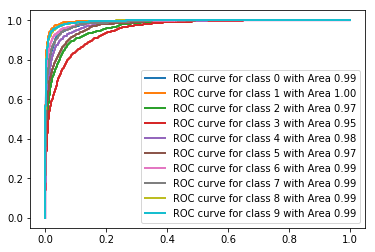

In [604]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.legend()

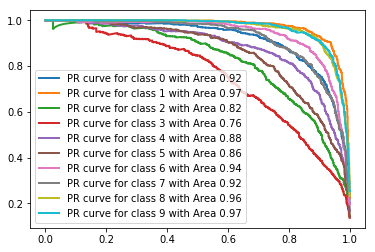

In [605]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.legend()

#### Micro的实现

In [606]:
gt_one_hot.ravel().shape

(100000,)

In [607]:
pred_soft.ravel().shape

(100000,)

In [608]:
fpr['micro'],tpr['micro'],_=roc_curve(gt_one_hot.ravel(),pred_soft.ravel())

In [609]:
prc['micro'],rcl['micro'],_=precision_recall_curve(gt_one_hot.ravel(),pred_soft.ravel())

In [610]:
ap['micro']=average_precision_score(gt_one_hot.ravel(),pred_soft.ravel(),average='micro')

In [611]:
roc_auc['micro']=auc(fpr['micro'],tpr['micro'])

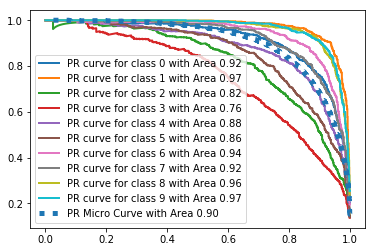

In [612]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.plot(rcl['micro'],prc['micro'],lw=5,linestyle=":",label='PR Micro Curve with Area %0.2f'%(ap['micro']))
    
plt.legend()


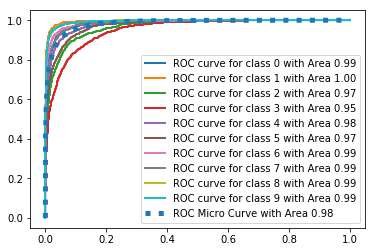

In [613]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.plot(fpr['micro'],tpr['micro'],lw=5,linestyle=":",label='ROC Micro Curve with Area %0.2f'%(roc_auc['micro']))
 
plt.legend()

#### Macro的计算

In [614]:
all_fpr=np.unique(np.concatenate([fpr[i] for i in range(10)]))

In [615]:
all_fpr.shape

(1116,)

In [616]:
all_prc=np.unique(np.concatenate([prc[i] for i in range(10)]))

In [617]:
all_prc.shape

(42506,)

In [618]:
mean_tpr=np.zeros_like(all_fpr)
mean_rcl=np.zeros_like(all_prc)

In [619]:
mean_tpr.shape

(1116,)

In [620]:
for i in range(10):
    mean_tpr+=interp(all_fpr,fpr[i],tpr[i])
    mean_rcl+=interp(all_prc,prc[i],rcl[i])

In [621]:
mean_tpr/=10

In [622]:
mean_rcl/=10

In [623]:
fpr['macro']=all_fpr
prc['macro']=all_prc
tpr['macro']=mean_tpr
rcl['macro']=mean_rcl
roc_auc['macro']=auc(fpr['macro'],tpr['macro'])
ap['macro']=average_precision_score(gt_one_hot.ravel(),pred_soft.ravel(),average='macro')

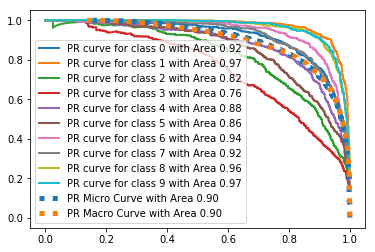

In [624]:
for i in range(10):
    plt.plot(rcl[i],prc[i],lw=2,label='PR curve for class %d with Area %0.2f'%(i,ap[i]))
plt.plot(prc['micro'],rcl['micro'],lw=5,linestyle=":",label='PR Micro Curve with Area %0.2f'%(ap['micro']))
plt.plot(prc['macro'],rcl['macro'],lw=5,linestyle=":",label='PR Macro Curve with Area %0.2f'%(ap['macro']))
    
plt.legend()



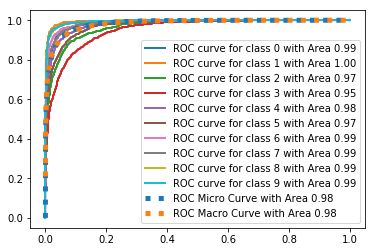

In [625]:
for i in range(10):
    plt.plot(fpr[i],tpr[i],lw=2,label='ROC curve for class %d with Area %0.2f'%(i,roc_auc[i]))
plt.plot(fpr['micro'],tpr['micro'],lw=5,linestyle=":",label='ROC Micro Curve with Area %0.2f'%(roc_auc['micro']))
plt.plot(fpr['macro'],tpr['macro'],lw=5,linestyle=":",label='ROC Macro Curve with Area %0.2f'%(roc_auc['macro']))
 
plt.legend()

#### mAP的计算

In [626]:
mAP=np.asanyarray([ap[i] for i in range(10)]).mean()

In [627]:
mAP

0.8991781695322398